In [1]:
import torch
from PIL import Image
import numpy as np
import sys,os

from torchvision import transforms

from tqdm import tqdm
import pdb

import pipeline.criterion as Criterion
from pipeline.load import get_dataloader
import pipeline.network as Network
import LovaszSoftmax.pytorch.lovasz_losses as L

import argparse
import evaluate as Eval

In [23]:
class ObjectView:
    '''
    Helper class to access dict values as attributes.

    Replaces command-line arg-parse options.
    '''
    def __init__(self, d):
        self.__dict__ = d


def img_frombytes(data):
    size = data.shape[::-1]
    databytes = np.packbits(data, axis=1)
    return Image.frombytes(mode='1', size=size, data=databytes)

def load_model_with_weights(model_name=None, num_epochs=8, batch_size=16, use_lovasz=True, se_loss=False, aux=False):
    '''
    Load a model by name from the /models subdirectory.
    '''

    options = {
        'use_jaccard': True,
        'use_lovasz': use_lovasz,
        'early_stopping': False,
        'validation': True,
        'model': 'encnet', # model name (default: encnet)
        'backbone': 'resnet50', # backbone name (default: resnet50)
        'jpu': True, # 'JPU'
        'dilated': True, # 'dilation'
        'lateral': False, #'employ FPN')
        'dataset':'ade20k', # 'dataset name (default: pascal12)')
        'workers': 16, # dataloader threads
        'base_size': 520, # 'base image size'
        'crop_size': 480, # 'crop image size')
        'train_split':'train', # 'dataset train split (default: train)'

        # training hyper params
        'aux': aux, # 'Auxilary Loss'
        'aux_weight': 0.2, # 'Auxilary loss weight (default: 0.2)'
        'se_loss': se_loss, # 'Semantic Encoding Loss SE-loss'
        'se_weight': 0.2, # 'SE-loss weight (default: 0.2)'
        'start_epoch': 0, # 'start epochs (default:0)'
        'batch_size': batch_size, # 'input batch size for training (default: auto)'
        'test_batch_size': None, # 'input batch size for testing (default: same as batch size)'
        'epochs':num_epochs,

        # optimizer params
        'optimizer': 'sgd',
        'lovasz_hinge': True,
        'lr': None, # 'learning rate (default: auto)'
        'lr_scheduler': 'poly', # 'learning rate scheduler (default: poly)'
        'momentum': 0.9, # 'momentum (default: 0.9)'
        'weight_decay': 1e-4, # 'w-decay (default: 1e-4)'

        # cuda, seed and logging
        'no_cuda': False, # 'disables CUDA training'
        'seed': 100, # 'random seed (default: 1)'

        # checking point
        'resume': None, # 'put the path to resuming file if needed'
        'checkname': 'default', # 'set the checkpoint name'
        'model-zoo': None, # 'evaluating on model zoo model'

        # finetuning pre-trained models
        'ft': False, # 'finetuning on a different dataset'

        # evaluation option
        'split': 'val',
        'mode': 'testval',
        'ms': False, # 'multi scale & flip'
        'no_val': False, # 'skip validation during training'
    }

    model_args = ObjectView(options)
    model = Network.get_model(model_args)

    if model_name[-5:] == '_m.pt':
        model_name = model_name[:-5]

    path_to_state_dict = 'models/{}/{}_m.pt'.format(model_name, model_name)
    model.load_state_dict(torch.load(path_to_state_dict))

    return model


def output_to_pred_imgs(output, dim=0, use_lovasz=False):
    
    if use_lovasz:
        np_pred = (output[0]>0).squeeze().cpu()
    else:
        np_pred = torch.max(output, dim=dim)[1].cpu().numpy()
    return img_frombytes(np_pred)


def predict_test_set(model, model_name, overwrite=False, use_lovasz=False):
    '''
    Predict for the entire submission set.
    '''

    out_dir = 'models/{}/predictions'.format(model_name)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    test_dataloader = get_dataloader(load_test=True, batch_size=4, overwrite=overwrite, out_dir=out_dir)
    if test_dataloader == False:
        print('Exiting...')
        sys.exit()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    print('Beginning Prediction Loop')
    tbar = tqdm(test_dataloader)
    for _, (image_tensors, img_names) in enumerate(tbar):        

        # Load tensors to GPU
        image_tensors = image_tensors.to(device)

        # Predict on image tensors
        with torch.no_grad():
            outputs = model(image_tensors)
            predict_imgs = [output_to_pred_imgs(output,use_lovasz=use_lovasz) for output in outputs]
            
        # Zip images, and save.
        for predict_img, img_name in zip(predict_imgs, img_names):
            image_out_path = 'models/{}/predictions/{}.tif'.format(model_name, img_name)
            predict_img.save(image_out_path, compression="tiff_deflate")

    return None


def score_region(model, model_name, region, thresh=0):
    '''
    evaluate and score for a single region. save results.
    '''

    test_dataloader = get_dataloader(
        in_dir='training_data', batch_size=8, region=region
        )
    device = torch.device('cpu')
    model.to(device)

    print('Beginning Prediction Loop')

    region_loss = 0

    region_ct = 0
    tbar = tqdm(test_dataloader)
    with open('region_scores.csv', 'a', newline='') as csvfile:
        csvwriter=csv.DictWriter(csvfile, fieldnames=['region', 'img_name', 'iou_score'])
        csvwriter.writeheader()
        for _, (images, masks, img_names) in enumerate(tbar):

            # Predict on image tensors
            with torch.no_grad():
                images = images.to(device)

                outputs = model(images)
                outputs = (outputs[0]>thresh).long().data
                masks = masks.to(device)

                for i, img_name in enumerate(np.array(img_names)):
                    loss = L.iou_binary(outputs[i], masks[i])
                    region_loss += loss
                    region_ct += 1
                    img_name = img_name.split('/')[-1]
                    csvwriter.writerow({'region':region, 'img_name':img_name, 'iou_score': loss})
        
        csvwriter.writerow({'region':region, 'img_name': 'avg_loss', 'iou_score': region_loss/region_ct})


    return None

In [24]:
MODEL_NAME = '11-03-2020_12-11__full_lovasz_trial_chkpt'
MODEL = load_model_with_weights(model_name=MODEL_NAME, use_lovasz=True)
MODEL.eval();

In [25]:
predict_test_set(model=MODEL, model_name=MODEL_NAME, use_lovasz=True)

  0%|          | 0/2871 [00:00<?, ?it/s]

Getting dataset.
Pulling from directory training_data
Loading Test
Beginning Prediction Loop


  0%|          | 6/2871 [00:06<53:51,  1.13s/it]  

KeyboardInterrupt: 

In [2]:
import glob

In [3]:
outputs = glob.glob('models/11-03-2020_12-11__full_lovasz_trial_chkpt/predictions/*')
len(outputs)

787

In [4]:
import matplotlib.pyplot as plt

In [5]:
from PIL import Image
import numpy as np

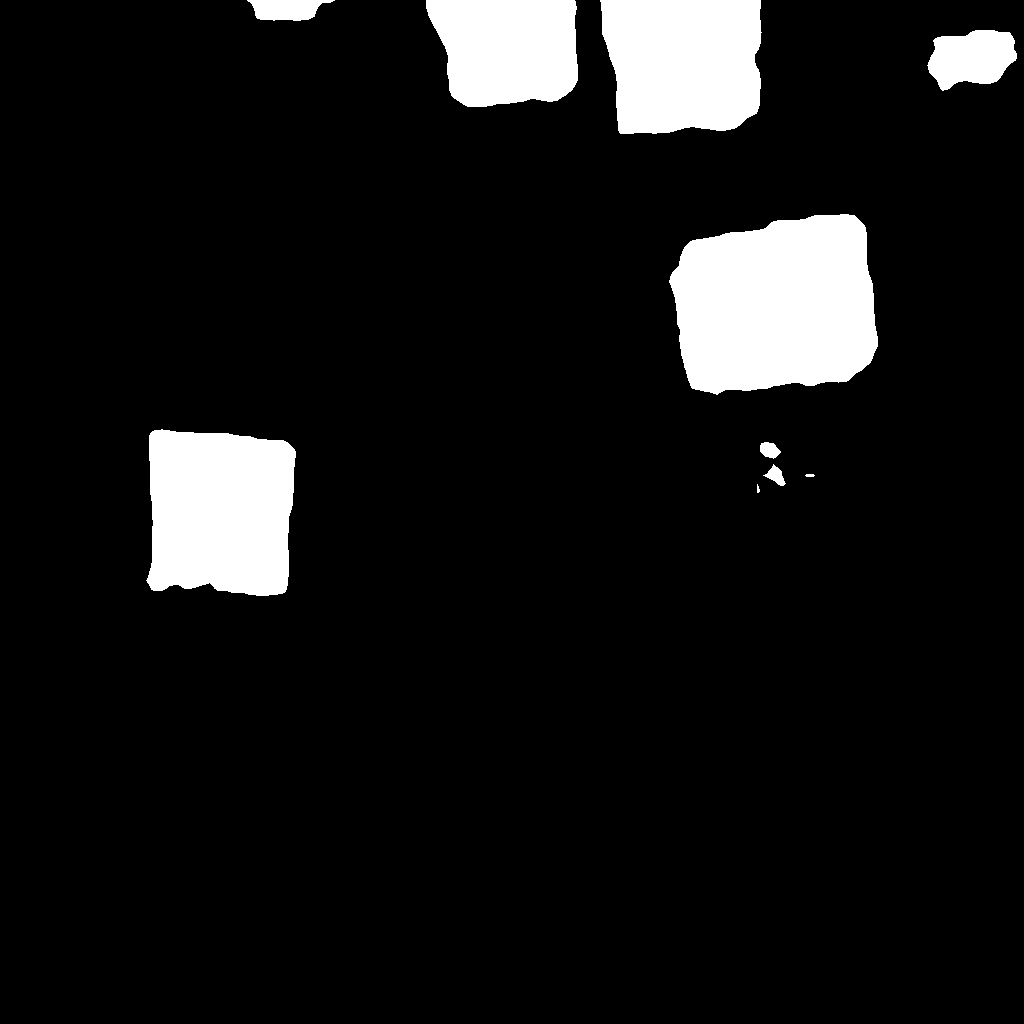

In [24]:
img = Image.open(outputs[700])
img

In [33]:
img.getbands

<bound method Image.getbands of <PIL.TiffImagePlugin.TiffImageFile image mode=1 size=1024x1024 at 0x7FE8288E6F90>>

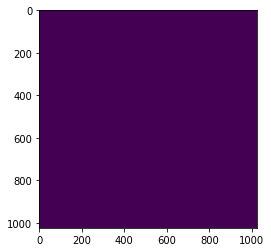

In [27]:
plt.imshow(np.array(img))